On perlmutter: use kernel pytorch-1.13.1

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
import pickle

import os
import torch


from numba import cuda 

from helpers.make_flow import *
from helpers.train_flow import *
from helpers.make_BC import *
from helpers.train_BC import *
from helpers.plotting import *
from helpers.evaluation import *

seed = 8

In [2]:
# computing

device = cuda.get_current_device()
device.reset()

# set the number of threads that pytorch will use
torch.set_num_threads(2)

# set gpu device
device = torch.device( "cuda" if torch.cuda.is_available() else "cpu")
print( "Using device: " + str( device ), flush=True)

Using device: cuda


In [3]:
# load in the data

bands = ["SBL", "IBL", "SR", "IBH", "SBH"]
data_dict = {}

feature_set = [9, 10, 12]
num_features = len(feature_set) - 1 # context doesn't count


num_layers = 2
num_hidden_features = 16
num_blocks = 4
early_stop_patience = 10


flow_training_id = f"Masked_PRQ_AR_{num_layers}layers_{num_hidden_features}hidden_{num_blocks}blocks_{seed}seed"
flow_training_dir = os.path.join("models", f"{flow_training_id}/")

with open(f"models/{flow_training_id}/flow_samples", "rb") as infile:
    
    data_dict = pickle.load(infile)
    
print(data_dict.keys())

dict_keys(['SBL', 'IBL', 'SR', 'IBH', 'SBH', 'SB', 'IB', 'SBL_samples', 'SBH_samples', 'SB_samples', 'IBL_samples', 'IBH_samples', 'IB_samples', 'SR_samples'])


## Evaluate the SB Samples

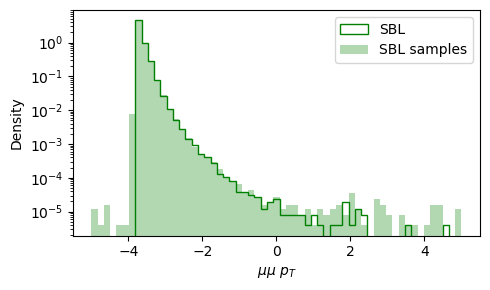

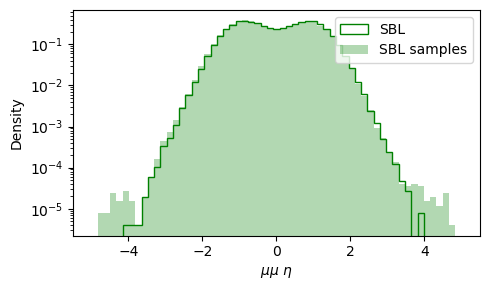

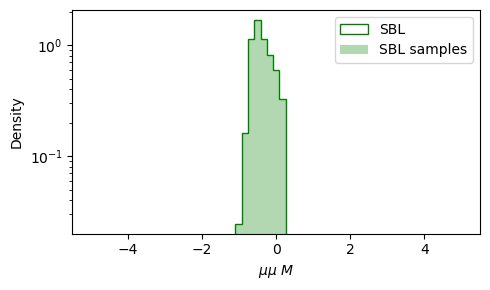

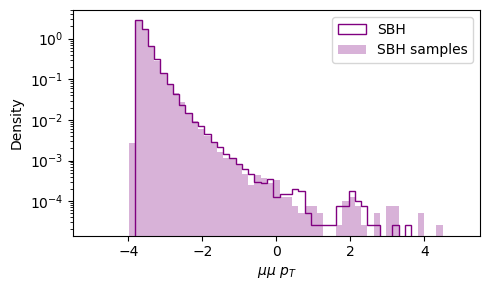

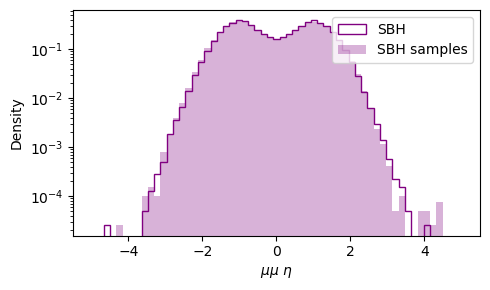

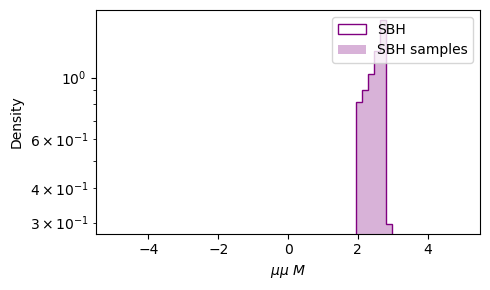

Feature 0 distance: 0.0022253914716778038
Feature 1 distance: 0.02935739994609344
Feature 2 distance: 0.0
Total distance: 0.01052759713925708


In [4]:
hist_all_features(["SBL", "SBL_samples"], data_dict, feature_set, kwargs_dict_bands, scaled_features = True, plot_bound = 5, yscale_log = True, image_path = "plots/low_SB")
hist_all_features(["SBH", "SBH_samples"], data_dict, feature_set, kwargs_dict_bands, scaled_features = True, plot_bound = 5, yscale_log = True, image_path = "plots/high_SB")



wds = get_1d_wasserstein_distances(data_dict["SB"], data_dict["SB_samples"])



for i, wd in enumerate(wds):
    print(f"Feature {i} distance: {wd}")
print(f"Total distance: {np.mean(wds)}")

Using seed 0...
Train data, labels shape: (3136888, 2) (3136888, 1)
Test data, labels  shape: (348544, 2) (348544, 1)
FOLD 0
--------------------------------


 29%|██▉       | 29/100 [16:04<39:21, 33.26s/it] 


Done training fold 0. Best val loss 0.6930351853370667 at epoch 24
FOLD 1
--------------------------------


 20%|██        | 20/100 [12:22<49:31, 37.14s/it]


Done training fold 1. Best val loss 0.693049430847168 at epoch 15
Loading in best model for models/Masked_PRQ_AR_2layers_16hidden_4blocks_8seed//.bc_fold0.pt, val loss 0.6930351853370667 from fold 0

Using seed 1...
Train data, labels shape: (3136888, 2) (3136888, 1)
Test data, labels  shape: (348544, 2) (348544, 1)
FOLD 0
--------------------------------


 12%|█▏        | 12/100 [07:56<58:13, 39.70s/it]


Done training fold 0. Best val loss 0.6930513381958008 at epoch 7
FOLD 1
--------------------------------


  6%|▌         | 6/100 [04:10<1:05:24, 41.75s/it]


Done training fold 1. Best val loss 0.6931014657020569 at epoch 1
Loading in best model for models/Masked_PRQ_AR_2layers_16hidden_4blocks_8seed//.bc_fold0.pt, val loss 0.6930513381958008 from fold 0

Using seed 2...
Train data, labels shape: (3136888, 2) (3136888, 1)
Test data, labels  shape: (348544, 2) (348544, 1)
FOLD 0
--------------------------------


 23%|██▎       | 23/100 [13:28<45:06, 35.14s/it]


Done training fold 0. Best val loss 0.6930481195449829 at epoch 18
FOLD 1
--------------------------------


  8%|▊         | 8/100 [04:54<56:27, 36.82s/it]


Done training fold 1. Best val loss 0.6930696368217468 at epoch 3
Loading in best model for models/Masked_PRQ_AR_2layers_16hidden_4blocks_8seed//.bc_fold0.pt, val loss 0.6930481195449829 from fold 0

0.5073847960174646 0.0005399425784741791
[0.507739005997677, 0.5066218510752277, 0.5077935309794891]


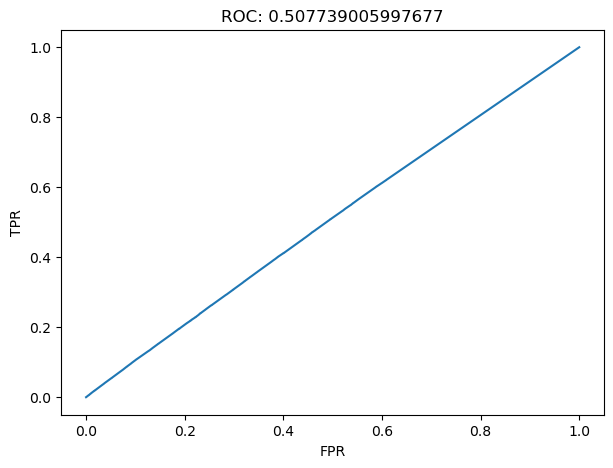

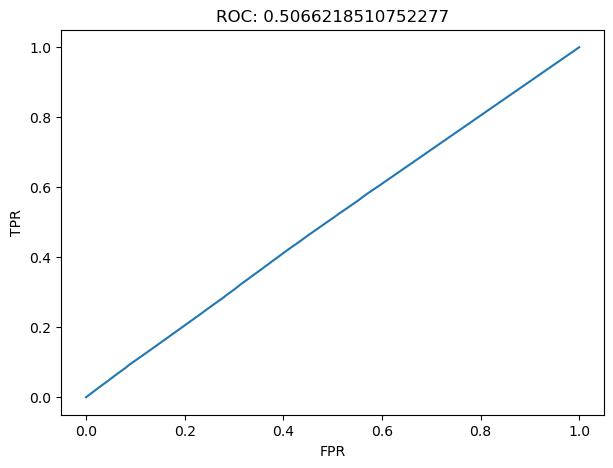

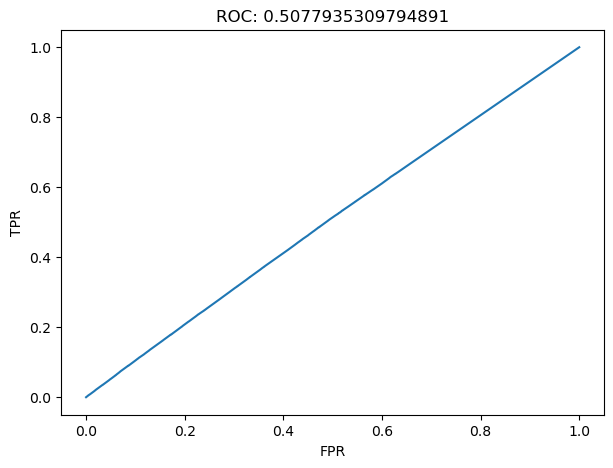

In [5]:
# Train a BC to discrim SB data from SB samples


hyperparameters_dict_BC = {"n_epochs":100,
                          "batch_size": 512,
                          "lr": 0.001,
                         }

SB_data_train, SB_data_test, SB_samples_train, SB_samples_test = train_test_split(data_dict["SB"], data_dict["SB_samples"], 
                                                                                  test_size=0.1, random_state=42)

#print(f"SB data train has shape {SB_data_train.shape}.")
#print(f"SB data test has shape {SB_data_test.shape}.")
#print(f"SB samples train has shape {SB_samples_train.shape}.")
#print(f"SB samples test has shape {SB_samples_test.shape}.")

n_runs = 3
auc_list = []


for i in range(n_runs):


    auc, fpr, tpr, outputs = discriminate_datasets_kfold(flow_training_dir, SB_data_train[:,:-1],  SB_samples_train[:,:-1], 
                                np.ones((SB_data_train.shape[0],1)), np.ones((SB_samples_train.shape[0],1)), 
                                   SB_data_test[:,:-1], SB_samples_test[:,:-1], 
                                num_features, hyperparameters_dict_BC, device, seed = i, visualize = False, k_folds = 2)


    fig, ax = plt.subplots(1, 1, figsize=(7, 5))
    ax.plot(fpr, tpr)
    ax.set_xlabel("FPR")
    ax.set_ylabel("TPR")
    ax.set_title("ROC: " + str(auc))
    
    auc_list.append(auc)
    
    print()

print(np.mean(auc_list), np.std(auc_list))

print(auc_list)


## Test the inner bands

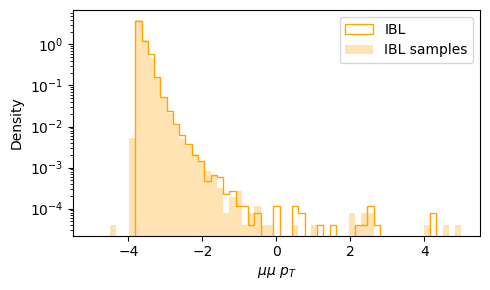

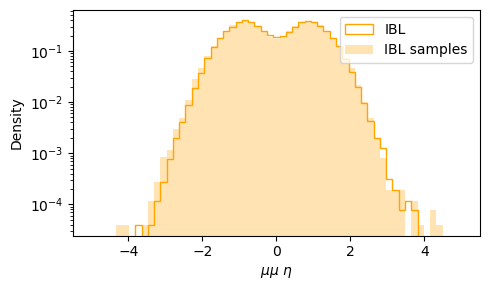

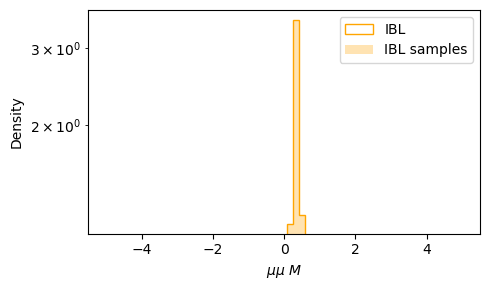

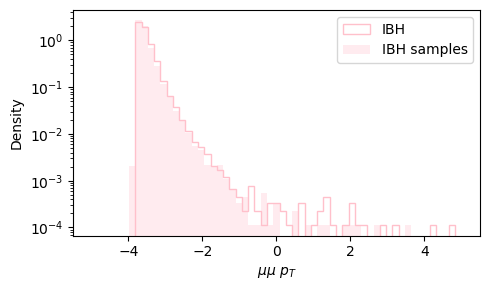

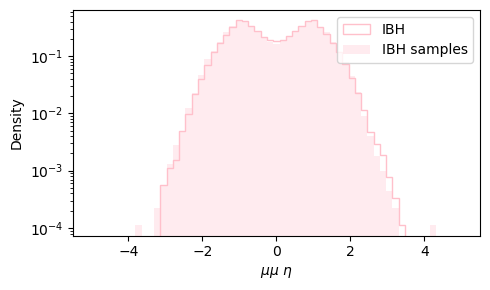

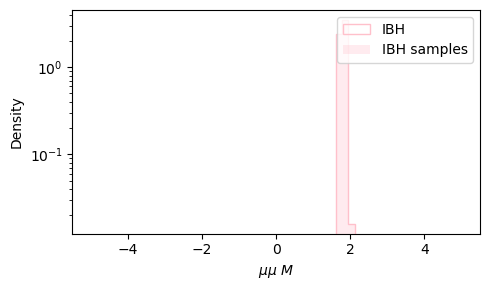

Feature 0 distance: 0.011802691566150138
Feature 1 distance: 0.02009580377499853
Feature 2 distance: 0.0
Total distance: 0.010632831780382887


In [5]:
hist_all_features(["IBL", "IBL_samples"], data_dict, feature_set, kwargs_dict_bands, yscale_log = True, plot_bound = 5, scaled_features = True, image_path = "plots/low_IB")
hist_all_features(["IBH", "IBH_samples"], data_dict, feature_set, kwargs_dict_bands, yscale_log = True, plot_bound = 5, scaled_features = True, image_path = "plots/high_IB")

wds = get_1d_wasserstein_distances(data_dict["IB"], data_dict["IB_samples"])

for i, wd in enumerate(wds):
    print(f"Feature {i} distance: {wd}")
print(f"Total distance: {np.mean(wds)}")

Using seed 0...
Train data, labels shape: (369928, 2) (369928, 1)
Test data, labels  shape: (41104, 2) (41104, 1)
FOLD 0
--------------------------------


  9%|▉         | 9/100 [00:37<06:15,  4.13s/it]


Done training fold 0. Best val loss 0.6931066513061523 at epoch 4
FOLD 1
--------------------------------


 14%|█▍        | 14/100 [00:58<05:58,  4.17s/it]


Done training fold 1. Best val loss 0.6930424571037292 at epoch 9
Loading in best model for models/Masked_PRQ_AR_2layers_16hidden_4blocks_8seed//.bc_fold1.pt, val loss 0.6930424571037292 from fold 1

Using seed 1...
Train data, labels shape: (369928, 2) (369928, 1)
Test data, labels  shape: (41104, 2) (41104, 1)
FOLD 0
--------------------------------


 18%|█▊        | 18/100 [01:14<05:37,  4.11s/it]


Done training fold 0. Best val loss 0.6930387020111084 at epoch 13
FOLD 1
--------------------------------


  7%|▋         | 7/100 [00:33<07:28,  4.83s/it]


Done training fold 1. Best val loss 0.693094789981842 at epoch 2
Loading in best model for models/Masked_PRQ_AR_2layers_16hidden_4blocks_8seed//.bc_fold0.pt, val loss 0.6930387020111084 from fold 0

Using seed 2...
Train data, labels shape: (369928, 2) (369928, 1)
Test data, labels  shape: (41104, 2) (41104, 1)
FOLD 0
--------------------------------


  7%|▋         | 7/100 [00:32<07:17,  4.71s/it]


Done training fold 0. Best val loss 0.6931195259094238 at epoch 2
FOLD 1
--------------------------------


 34%|███▍      | 34/100 [02:24<04:40,  4.25s/it]


Done training fold 1. Best val loss 0.6927512288093567 at epoch 29
Loading in best model for models/Masked_PRQ_AR_2layers_16hidden_4blocks_8seed//.bc_fold1.pt, val loss 0.6927512288093567 from fold 1

0.508956342715163 0.0032116748727441134
[0.5070726685216328, 0.5063189184521227, 0.5134774411717333]


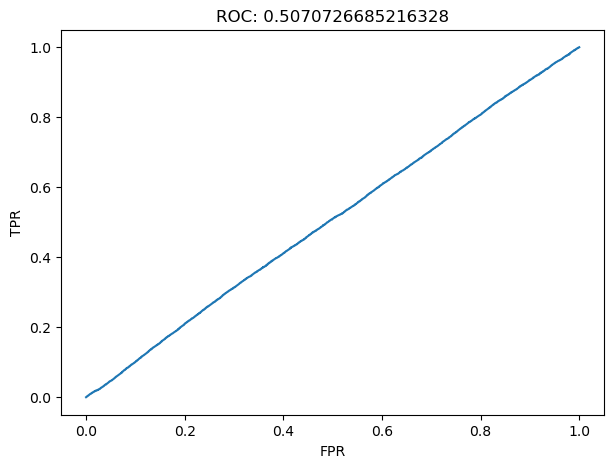

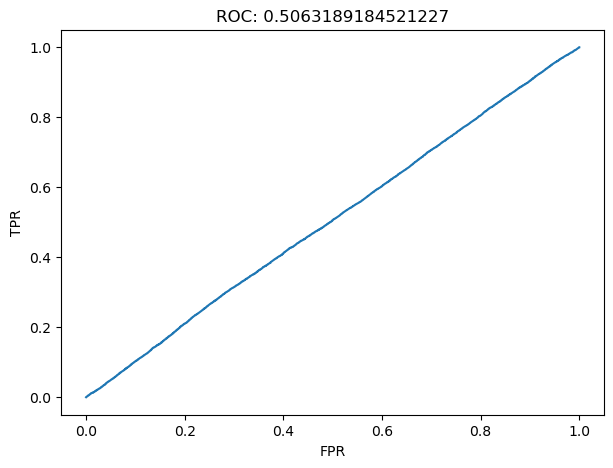

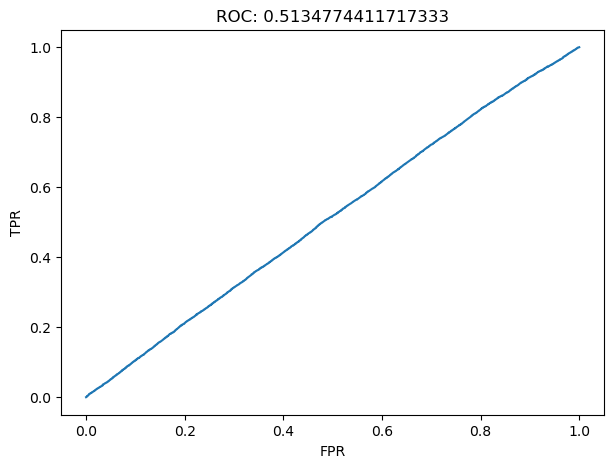

In [7]:

IB_data_train, IB_data_test, IB_samples_train, IB_samples_test = train_test_split(data_dict["IB"], data_dict["IB_samples"], 
                                                                                  test_size=0.1, random_state=42)

#print(f"IB data train has shape {IB_data_train.shape}.")
#print(f"IB data test has shape {IB_data_test.shape}.")
#print(f"IB samples train has shape {IB_samples_train.shape}.")
#print(f"IB samples test has shape {IB_samples_test.shape}.")

n_runs = 3
auc_list = []

for i in range(n_runs):


    auc, fpr, tpr, outputs = discriminate_datasets_kfold(flow_training_dir, IB_data_train[:,:-1],  IB_samples_train[:,:-1], 
                                np.ones((IB_data_train.shape[0],1)), np.ones((IB_samples_train.shape[0],1)), 
                                   IB_data_test[:,:-1], IB_samples_test[:,:-1], 
                                num_features, hyperparameters_dict_BC, device, seed = i, visualize = False, k_folds = 2)


    fig, ax = plt.subplots(1, 1, figsize=(7, 5))
    ax.plot(fpr, tpr)
    ax.set_xlabel("FPR")
    ax.set_ylabel("TPR")
    ax.set_title("ROC: " + str(auc))
    
    auc_list.append(auc)
    
    print()


print(np.mean(auc_list), np.std(auc_list))

print(auc_list)

